# Controlador de vuelo para vehículos aéreos no tripulados multi-rotor basado en técnicas de aprendizaje profundo

## Entrenamiento Red LSTM

### Javier Cárdenas - Uriel Carrero

## 1. Descripción del Dataset

#### Importar Librerías

In [1]:
import os
import sys
import random

import pandas as pd
pd.set_option('display.max_columns', None) #Para mostrar todas las columnas
import matplotlib.pyplot as plt

import numpy as np                  # Cómputo Numérico
print(np.__version__)
assert (np.__version__=='1.19.5'), 'Versión incorrecta de numpy, por favor instale 1.19.5'
seed = 5
np.random.seed(seed)
np.seterr(divide = 'ignore')

1.19.5


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import keras as kr

import tensorflow as tf
from tensorflow.keras import models, layers
print(tf.__version__)
assert (tf.__version__=='2.5.0'), 'Versión incorrecta de Tensorflow, por favor instale 2.5.0'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from IPython.display import clear_output

2.5.0
Num GPUs Available:  1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
config = ConfigProto()
if gpus:
    try:
        config.gpu_options.allow_growth = True
        tf.compat.v1.enable_eager_execution()

        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
session = InteractiveSession(config=config)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import gc #garbage collector
import gc; gc.enable()

## Cargar Datos

### Leemos el Dataset

In [5]:
root = '../logs/Datasets/'
dataset_name = 'Dataset_Final'
rootdir = root+dataset_name
if not os.path.exists(rootdir):
    print(f"{rootdir} not exist")

In [6]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
delete_list = ['timestamps',
               'Q1', 'Q2', 'Q3', 'Q4', 
               'uvx', 'uvy', 'uvz', 
               'up', 'uq', 
               'uwp', 'uwq', 'uwr']
df_list = df.columns.to_list()
rpm_list = [i for i in df_list if ("RPM" in i)]
states_list = [i for i in df_list if not ((i in delete_list) or (i in rpm_list))]
Ts = df['timestamps'][1]-df['timestamps'][0]
fs = 1/Ts

In [7]:
dataset = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
        
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    x = df.drop(rpm_list, axis=1)
    y = df.drop(states_list, axis=1)
    dataset.append([x, y])

df = None
x = None
y= None

In [8]:
rpm_list

['RPM0', 'RPM1', 'RPM2', 'RPM3']

#### Normalización de Estados (Entradas) y Acciones (Salidas)

In [9]:
def Norm(df, df_desc):
    for prop in list(df.columns):
        try:
            # 1 ~ Mean  7 ~ Max  3 ~ Min
            df[prop] = (df[prop]-df_desc[prop]['mean'])/(df_desc[prop]['max']-df_desc[prop]['min'])
        except e:
            print(e)
    return df

In [10]:
norm_data_path = f"{root}/data_description_{dataset_name}.csv"
df_desc = pd.read_csv(norm_data_path, index_col=0)  
df_desc

,x,y,z,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,ur
count,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06,3.068233e+06
mean,6.352137e-03,3.631930e-03,8.701060e-01,8.113104e-04,7.632901e-04,1.239124e-02,-1.253432e-04,-2.641033e-04,1.198860e-03,4.372706e-06,1.434372e-04,2.558978e-03,-1.772714e-05,3.597617e-05,-2.469848e-05,1.224907e-04,5.466858e-05,-3.303912e-05,1.441162e+04,1.441290e+04,1.440977e+04,1.441093e+04,6.439717e-03,3.417250e-03,8.782731e-01,1.285404e-02
std,1.067096e-01,1.015022e-01,7.571069e-01,3.005110e-02,3.288610e-02,4.450773e-01,7.177616e-02,6.552093e-02,2.601583e-01,1.942947e-01,2.135545e-01,5.107082e-01,3.168708e-01,2.945918e-01,1.454656e+00,7.742095e+00,6.830287e+00,3.325449e+00,1.055152e+03,1.058528e+03,1.058532e+03,1.058966e+03,1.058331e-01,1.010920e-01,7.641660e-01,4.414466e-01
min,-8.166897e-01,-8.176113e-01,2.113373e-04,-4.872289e-01,-4.386099e-01,-3.141419e+00,-1.156056e+00,-8.621260e-01,-6.841123e+00,-1.045986e+01,-7.981405e+00,-7.181414e+00,-4.279933e+01,-3.656422e+01,-9.800000e+00,-2.510366e+03,-3.059815e+03,-2.531001e+02,9.440300e+03,9.440300e+03,9.440300e+03,9.440300e+03,-8.000000e-01,-8.000000e-01,0.000000e+00,-3.140685e+00
25%,-7.023093e-03,-4.566531e-03,3.597720e-01,-7.548420e-04,-1.295726e-03,-3.379343e-04,-2.080171e-03,-1.373874e-03,-1.070760e-02,-5.708022e-03,-8.702793e-03,-6.507613e-05,-1.356462e-02,-7.912034e-03,-4.078746e-02,-4.151471e-02,-6.752393e-02,-2.696169e-04,1.438274e+04,1.438057e+04,1.438241e+04,1.437958e+04,0.000000e+00,0.000000e+00,3.549988e-01,0.000000e+00
50%,9.264773e-05,8.164912e-06,9.371726e-01,0.000000e+00,2.258764e-17,0.000000e+00,-1.518968e-08,1.364815e-17,3.785519e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.865757e-05,0.000000e+00,0.000000e+00,0.000000e+00,1.446835e+04,1.446836e+04,1.446834e+04,1.446834e+04,0.000000e+00,0.000000e+00,9.364582e-01,0.000000e+00
75%,2.154385e-02,1.321506e-02,1.092425e+00,9.607826e-04,1.469981e-03,5.312049e-04,2.095210e-03,1.519517e-03,1.501362e-02,5.440229e-03,8.939743e-03,3.879907e-05,1.237756e-02,8.299066e-03,3.374101e-02,4.180967e-02,6.758204e-02,3.539114e-04,1.452948e+04,1.453062e+04,1.452831e+04,1.452817e+04,1.838854e-02,8.750144e-03,1.144531e+00,0.000000e+00
max,8.194435e-01,8.146467e-01,8.073860e+00,3.767827e-01,4.339304e-01,3.141577e+00,8.494385e-01,8.597021e-01,6.373837e+00,7.147506e+00,1.179763e+01,7.300762e+00,3.906528e+01,3.332884e+01,1.921161e+02,2.711637e+03,2.831431e+03,1.630572e+02,2.166645e+04,2.166645e+04,2.166645e+04,2.166645e+04,8.000000e-01,8.000000e-01,7.998727e+00,3.141519e+00


In [11]:
for i, data in enumerate(dataset):
    x, y = data
    Norm(x, df_desc)
    Norm(y, df_desc)
    dataset[i]=[x,y]

#### División del dataset para entrenamiento, validación, prueba

In [12]:
X = []
Y = []

for sample in dataset:
    x, y = sample
    X.append(x)
    Y.append(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
X_train,  X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.1)

del X
del Y

In [13]:
print(f'Total={len(dataset)}, Entrenamiento={len(X_train)} ({round(100*len(X_train)/len(dataset))}%),'\
      f'Validación={len(X_val)} ({round(100*len(X_val)/len(dataset))}%),'\
      f'Prueba={len(X_test)} ({round(100*len(X_test)/len(dataset))}%)')

Total=167, Entrenamiento=142 (85%),Validación=16 (10%),Prueba=9 (5%)


#### Generador de Ejemplos de entrenamiento

Entrenar un modelo con una señal de 50000 datos en cada iteración sería una tarea que tomaría demasiado tiempo, así mismo, cuando se necesite realizar la inferencia del modelo, se necesitaría esa misma cantidad de datos, por lo que no se utiliza toda la señal de entrenamiento, sino pequeños segmentos de tamaño N, por lo que se generarán M-N (longitud de toda la señal, 50000) señales de longitud N para el entrenamiento, lo que aumentaría el consumo de memoria. Por tal motivo se define un generador.

In [14]:
class DataGenerator:
    def __init__(self, X=[], Y=[], dataset = None, batch_size=512, window=512, sequence_out=False, variable_window=False, delta_window=1, feedback=False, window_feedback=1):
        if dataset:
            for data in dataset:
                X.append(data[0])
                Y.append(data[1])
            self.X = X
            self.Y = Y
        elif X and Y:
            if len(X)!=len(Y):
                raise Exception("La longitud de datos de X e Y deben ser iguales")
            self.X = X
            self.Y = Y
        else:
            raise Exception("Debe especificar dataset o X, Y")
            
        self.n  = len(X)                 ### Número de ejemplos de entrenamiento
        x_shape = X[0].shape
        y_shape = Y[0].shape
        self.batch_size = batch_size
        self.window = window
        self.variable_window = variable_window
        self.delta_window = delta_window
        self.feedback = feedback
        self.i  = x_shape[1] if not self.feedback else x_shape[1]+y_shape[1]   ### Número de características
        self.j  = y_shape[1]                                                   ### Número de salidas
        #self.window_feedback = window_feedback
        if self.variable_window:
            self.window_max = self.window+self.delta_window
            self.window_min = self.window-self.delta_window
            if self.window_min<1:
                raise IndexError(f'delta_window no puede ser igual o mayor a la ventana')
        self.sequence_out = sequence_out
        self.set_shapes()
        
    def set_shapes(self):
        if self.sequence_out:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.window, self.j))
        else:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.j))

    def buid_init(self):
        if self.variable_window:
            self.window = np.random.randint(self.window_min, self.window_max)
            self.set_shapes()
        self.samples = np.empty(shape= self.shapes[0], dtype='float32') 
        self.labels  = np.empty(shape= self.shapes[1], dtype='float32') 
        self.batchcount = 0
        
    def build_data(self):
        self.buid_init()
        if self.feedback:
            i_0 = 1
        else:
            i_0 = 0
        while True:
            try:
                index = np.random.randint(0, self.n-1)            ### Trayectoria a seleccionar
                m = len(self.X[index])          ### Número de steps por ejemplo
                if m-self.window-1<=0:
                    raise IndexError(f'El tamaño de la ventana es mayor a la trayectoria')
                else:
                    start_index = np.random.randint(i_0, int(m-self.window-1))
                    final_index = start_index+self.window
                    x = self.X[index][start_index:final_index].to_numpy()
                    if self.feedback:
                        y = self.Y[index][start_index-1:final_index-1].to_numpy()
                        self.samples[self.batchcount] = np.concatenate((x,y), axis=1)
                    else:
                        self.samples[self.batchcount] = x
                        
                    if self.sequence_out:
                        self.labels[self.batchcount] = self.Y[index][start_index:final_index].to_numpy()
                    else:
                        self.labels[self.batchcount] = self.Y[index].loc[final_index]
            except IndexError as e:
                print(f'ERROR: Ejemplo {self.batchcount}: {e}')
                raise e
                
            self.batchcount += 1
            if self.batchcount >= self.batch_size:
                yield self.samples.astype(np.float32), self.labels.astype(np.float32)
                self.buid_init()

In [15]:
window = 64                    ### Número de steps por ejemplo
batch_size = 512              ### Número de ejemplos por batch
sequence_out = False
variable_window=True
feedback = False
delta_window=window/3

In [16]:
train_generator = DataGenerator(X=X_train, Y=Y_train, batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)
val_generator   = DataGenerator(X=X_val,   Y=Y_val,   batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)
test_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)

In [17]:
dataset_train = tf.data.Dataset.from_generator(train_generator.build_data,
                                        output_types = (tf.float32, tf.float32))
dataset_val = tf.data.Dataset.from_generator(val_generator.build_data,
                                        output_types = (tf.float32, tf.float32))
dataset_test = tf.data.Dataset.from_generator(test_generator.build_data,
                                        output_types = (tf.float32, tf.float32))

In [18]:
for _ in range(5):
    x, y = next(train_generator.build_data())
    print(f'x.shape={x.shape}, y.shape={y.shape}')

x.shape=(512, 61, 22), y.shape=(512, 4)
x.shape=(512, 48, 22), y.shape=(512, 4)
x.shape=(512, 66, 22), y.shape=(512, 4)
x.shape=(512, 68, 22), y.shape=(512, 4)
x.shape=(512, 74, 22), y.shape=(512, 4)


## Keras Model

## Callbacks

In [19]:
main_metric = 'mean_squared_error'
#metrics = [main_metric, 'cosine_similarity', 'logcosh']
metrics = main_metric

#### Early Stopping

In [20]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor=f'val_{main_metric}', min_delta=0, patience=15, verbose=0, mode='auto')

#### Plotting

In [21]:
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self, loss, figsize=(10,10)):
        self.loss = loss
        self.figsize = figsize
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.fig = plt.figure(figsize=self.figsize)
        if type(self.loss)==list:
            self.N = len(self.loss)
            for i in range(self.N):
                self.losses.append([])
                self.val_losses.append([])
        else:
            self.N = 1
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i+1)
        if self.N>1:
            for i, l in enumerate(self.loss):
                self.losses[i].append(logs.get(f'{l}'))
                self.val_losses[i].append(logs.get(f'val_{l}'))
        else:
            self.losses.append(logs.get(f'{self.loss}'))
            self.val_losses.append(logs.get(f'val_{self.loss}'))
        self.i += 1
        
        clear_output(wait=True)
        if self.N>1:
            self.fig, self.axs = plt.subplots(self.N, sharex=True, figsize=self.figsize)
            for i, l in enumerate(self.loss):
                self.axs[i].plot(self.x, self.losses[i], label=f"Train")
                self.axs[i].plot(self.x, self.val_losses[i], label=f"Validation")
                self.axs[i].set_title(f'{l}')
                self.axs[i].set_yscale('log')
                self.axs[i].grid()
                self.axs[i].legend()
            self.axs[i].set_xlabel('Epochs')
        else:
            plt.plot(self.x, self.losses, label=f"Train")
            plt.plot(self.x, self.val_losses, label=f"Validation")
            plt.suptitle(f'{self.loss}')
            plt.yscale('log')
            plt.xlabel('Epochs')
            plt.grid()
            plt.legend()
        plt.show()

#### Checkpoints

In [22]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=f'val_{main_metric}',
    mode='min',
    save_best_only=True)

In [23]:
plot_losses = PlotLosses(loss=metrics)
#callbacks = [model_checkpoint_callback, Early_Stopping, plot_losses]
callbacks = [model_checkpoint_callback, plot_losses]

#### Definición del Modelo

In [24]:
input_dim = len(states_list) if not feedback else len(states_list)+len(rpm_list)
output_dim = len(rpm_list)
print(f'input_dim: {input_dim}, output_dim: {output_dim}')

input_dim: 22, output_dim: 4


In [25]:
# model = models.Sequential()
# model.add(layers.LSTM(256, input_shape=(None, input_dim), return_sequences=True))
# #model.add(layers.Conv1D(filters=256, kernel_size=7, padding='same', activation='relu'))
# model.add(layers.LSTM(128, return_sequences=True))
# #model.add(layers.Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
# model.add(layers.LSTM(64, return_sequences=True))
# #model.add(layers.Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
# model.add(layers.LSTM(32))
# #model.add(layers.LSTM(shapes[1][1]))#, return_sequences=True))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(output_dim))

In [26]:
# model = models.Sequential()
# model.add(layers.LSTM(320, input_shape=(None, input_dim), return_sequences=True))
# model.add(layers.Conv1D(filters=480, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.LSTM(128, return_sequences=True))
# model.add(layers.Conv1D(filters=288, kernel_size=3, padding='same', activation='relu'))
# #model.add(layers.LSTM(64, return_sequences=True))
# #model.add(layers.Conv1D(filters=64, kernel_size=7, padding='same', activation='relu'))
# model.add(layers.LSTM(128))
# #model.add(layers.LSTM(shapes[1][1]))#, return_sequences=True))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(96, activation='relu'))
# model.add(layers.Dense(320, activation='relu'))
# model.add(layers.Dense(192, activation='relu'))
# model.add(layers.Dense(output_dim))

In [27]:
# #Tuner 0
# model = models.Sequential()
# model.add(layers.Conv1D(filters=224, kernel_size=3, padding='same', activation='relu', input_shape=(None, input_dim)))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=224, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=416, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.LSTM(224, return_sequences=True))
# model.add(layers.LSTM(192, return_sequences=True))
# model.add(layers.LSTM(128, return_sequences=True))
# model.add(layers.LSTM(192, return_sequences=True))
# model.add(layers.LSTM(96))
# model.add(layers.Dense(448, activation='relu'))
# model.add(layers.Dense(192, activation='relu'))
# model.add(layers.Dense(224, activation='relu'))
# model.add(layers.Dense(output_dim))

In [28]:
# # Tuner 1
# model = models.Sequential()
# model.add(layers.Conv1D(filters=480, kernel_size=3, padding='same', activation='relu', input_shape=(None, input_dim)))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=192, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=480, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.LSTM(128, return_sequences=True))
# model.add(layers.LSTM(64))
# model.add(layers.Dense(480, activation='relu'))
# model.add(layers.Dense(224, activation='relu'))
# model.add(layers.Dense(224, activation='relu'))
# model.add(layers.Dense(480, activation='relu'))
# model.add(layers.Dense(output_dim))

In [29]:
# #Tuner 2
# model = models.Sequential()
# model.add(layers.Conv1D(filters=160, kernel_size=3, padding='same', activation='relu', input_shape=(None, input_dim)))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.Conv1D(filters=288, kernel_size=3, padding='same', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.LSTM(192, return_sequences=True))
# model.add(layers.LSTM(96))
# model.add(layers.Dense(96, activation='relu'))
# model.add(layers.Dense(480, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(output_dim))

In [30]:
# model = models.Sequential()
# # model.add(layers.Conv1D(filters=480, kernel_size=3, padding='same', activation='relu', input_shape=(None, input_dim)))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# # model.add(layers.Conv1D(filters=288, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# #model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
# model.add(layers.LSTM(320, return_sequences=True, input_shape=(None, input_dim)))
# model.add(layers.LSTM(128, return_sequences=True))
# model.add(layers.LSTM(128))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(96, activation='relu'))
# model.add(layers.Dense(320, activation='relu'))
# model.add(layers.Dense(192, activation='relu'))
# model.add(layers.Dense(output_dim))

In [47]:
# LSTM 1
model = models.Sequential()
model.add(layers.LSTM(224, return_sequences=True, input_shape=(None, input_dim)))
model.add(layers.LSTM(192, return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(192, return_sequences=True))
model.add(layers.LSTM(96))
model.add(layers.Dense(448, activation='tanh'))
model.add(layers.Dense(192, activation='tanh'))
model.add(layers.Dense(224, activation='tanh'))
model.add(layers.Dense(224, activation='tanh'))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(output_dim))

In [41]:
# # LSTM 2
# model = models.Sequential()
# model.add(layers.LSTM(64, return_sequences=False, input_shape=(None, input_dim)))
# model.add(layers.Dense(192, activation='relu'))
# model.add(layers.Dense(416, activation='relu'))
# model.add(layers.Dense(192, activation='relu'))
# model.add(layers.Dense(416, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(output_dim))

In [ ]:
# LSTM 4
# model = models.Sequential()
# model.add(layers.LSTM(224, return_sequences=True, input_shape=(None, input_dim)))
# model.add(layers.LSTM(192, return_sequences=True))
# model.add(layers.LSTM(128, return_sequences=True))
# model.add(layers.LSTM(192, return_sequences=True))
# model.add(layers.LSTM(196))
# model.add(layers.Dense(448, activation='tanh'))
# model.add(layers.Dense(192, activation='tanh'))
# model.add(layers.Dense(224, activation='tanh'))
# model.add(layers.Dense(output_dim))

In [30]:
# LSTM 5
# model = models.Sequential()
# model.add(layers.LSTM(416, return_sequences=True, input_shape=(None, input_dim)))
# model.add(layers.LSTM(288, return_sequences=True))
# model.add(layers.LSTM(384, return_sequences=True))
# model.add(layers.LSTM(288))
# model.add(layers.Dense(448, activation='tanh'))
# model.add(layers.Dense(192, activation='tanh'))
# model.add(layers.Dense(224, activation='tanh'))
# model.add(layers.Dense(224, activation='tanh'))
# model.add(layers.Dense(512, activation='tanh'))
# model.add(layers.Dense(output_dim))

#### Optimizador con learning decay

In [48]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-3,
#     decay_steps=len(X_train),
#     decay_rate=0.95)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
optimizer = tf.keras.optimizers.Adam(clipvalue=0.5, clipnorm=1.0)
#optimizer = tf.keras.optimizers.Adam()

#### Compilado el Modelo

In [49]:
model.compile(loss=main_metric, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 224)         221312    
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 192)         320256    
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 128)         164352    
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 192)         246528    
_________________________________________________________________
lstm_19 (LSTM)               (None, 96)                110976    
_________________________________________________________________
dense_22 (Dense)             (None, 448)               43456     
_________________________________________________________________
dense_23 (Dense)             (None, 192)              

#### Entrenamiento del Modelo

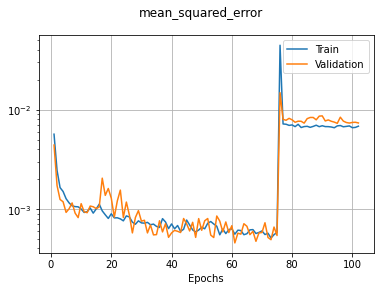

Epoch 103/150
141/142 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

KeyboardInterrupt: 

In [50]:
%%time
EPOCHS = 150
#se usa el repeat para llamar al generador mas de una vez
#steps_per_epoch  = numero de batches de los datos para determinar una epoca terminada 
#Por defecto -> number of samples in your dataset divided by the batch size (LEN_DT//BATCH_SIZE_TRAIN)
#verbose = mostrar el avance del entrenamiento
#validation_steps = numero de batches de datos para validar en cada epoca
#workers?
#max_queue_size?
history = model.fit(dataset_train.repeat(), 
                    epochs=EPOCHS, 
                    steps_per_epoch = len(X_train),
                    callbacks=callbacks, 
                    verbose=1,
                    validation_data = dataset_val.repeat(),
                    validation_steps= len(X_val))

#### Se guarda el Modelo

In [51]:
I = 'LSTM_1_2'

In [52]:
model.save(f'../Models/{dataset_name}_{I}.h5')
print(f'../Models/{dataset_name}_{I}.h5')

../Models/Dataset_Final_LSTM_1_2.h5


### Evaluación del Modelo

#### Se carga el modelo

In [25]:
I = 'CLSTM'
j = 'Tunner_2'

In [26]:
#model = tf.keras.models.load_model(f'../Models/{I}/{dataset_name}_{I}_{j}.h5')
#model = tf.keras.models.load_model(f'../Models/{dataset_name}_{I}_{j}.h5')
model = tf.keras.models.load_model(f'../Models/Dataset_Final_LSTMCNN_Tuner_4.h5')
#model = tf.keras.models.load_model(f'../tmp/LSTMCNN/Dataset_Final_LSTMCNN_Tuner_2.h5')
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 320)         439040    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 480)         461280    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         311808    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 288)         110880    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               213504    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                6

In [39]:
window = 8                    ### Número de steps por ejemplo
batch_size = 512              ### Número de ejemplos por batch
sequence_out = False
variable_window=False
feedback = False
delta_window=window/3

In [40]:
test_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)
dataset_test = tf.data.Dataset.from_generator(test_generator.build_data,
                                        output_types = (tf.float32, tf.float32))

#### Evaluación con dataset de prueba

In [41]:
%%time
N = 0
for i in range(len(X_test)):
    N+=len(X_test[i])
N=N/len(X_test)

n_batches = np.ceil(N/batch_size)
losses = model.evaluate(dataset_test, steps = n_batches)
K = df_desc[rpm_list[0]][7]-df_desc[rpm_list[0]][3] #Ganancia del actuador
print(f'K={"{:.2f}".format(K)}')
if not type(metrics) == list:
    metrics = [metrics]
for i, l in enumerate(['loss']+metrics):
    print(f'{l}: {"{:.2e}".format(losses[i])} -> {"{:.2f}".format(losses[i]*K)} RPM')

45/45 [==============================] - 4s 95ms/step - loss: 0.0108 - mean_squared_error: 0.0108
K=12226.15
loss: 1.08e-02 -> 131.76 RPM
mean_squared_error: 1.08e-02 -> 131.76 RPM
Wall time: 4.43 s


#### Evaluación con 1 trayectoria

In [27]:
window_test = 3000
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=1, window=window_test, sequence_out=True, feedback=feedback)

In [28]:
%%time
X, Y = next(test_traj_generator.build_data())
offset = 8
x = X[0]
y = Y[0]
y = y[offset:]
y_pred = []
for i in range(offset, len(x)):
    #if i <= offset:
        #continue
        #x_temp = x[0].reshape(1,  1, X.shape[2])
    if i<=window:
        x_temp = x[0:i].reshape(1,  i, X.shape[2])
    else:
        x_temp = x[i-window:i].reshape(1,  window, X.shape[2])
    y_temp = model.predict(x_temp)
    y_pred.append(y_temp)
y_pred = np.array(y_pred).reshape(y.shape)

Wall time: 1min 59s


#### Visualización con 1 trayectoria

In [29]:
t = np.arange(0, len(y)*Ts, Ts)

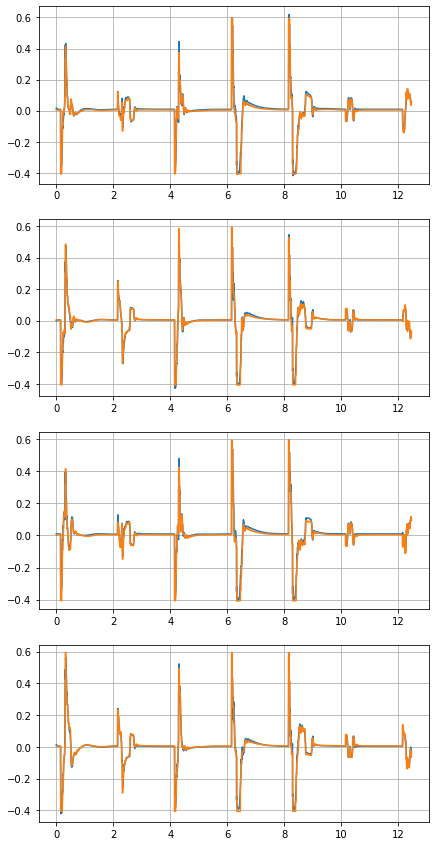

In [30]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
for i in range(Y.shape[2]):
    axs[i].plot(t, y_pred[:,i], t, y[:,i])
    axs[i].grid()

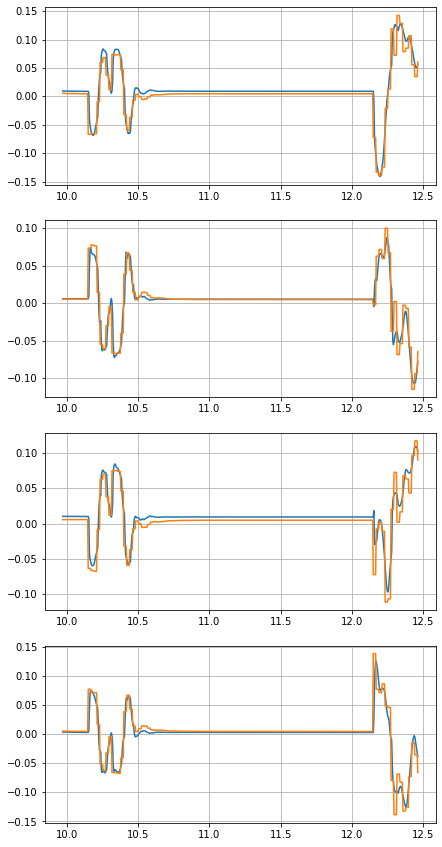

In [31]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
L1 = 4*len(t)//5
L2 = 5*len(t)//5
for i in range(Y.shape[2]):
    axs[i].plot(t[L1:L2], y_pred[L1:L2,i], t[L1:L2:], y[L1:L2:,i])
    axs[i].grid()

### Comparación LSTM

In [87]:
# model_paths= [
#     '../tmp/LSTM/Dataset_Final_LSTM_0.h5', #1
#     '../tmp/LSTM/Dataset_Final_LSTM_1.h5', #2
#     '../tmp/LSTM/Dataset_Final_LSTM_2.h5', #3
#     '../tmp/LSTM/Dataset_Final_LSTM_3.h5', #4
#     '../tmp/LSTM/Dataset_Final_LSTM_4.h5' #5
# ]
model_paths= [
    '../tmp/CLSTM/Dataset_Final_CLSTM_0.h5', #1
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_0_2.h5', #2
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_1_0.h5', #3
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_2.h5', #4
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_3.h5', #5
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_2_2.h5', #6
    '../tmp/CLSTM/Dataset_Final_CLSTM_Tuner_1_2.h5' #7
]


models = []
for path in model_paths:
    model = tf.keras.models.load_model(f'{path}')
    model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')
    model.save(f'{path}')
    models.append(model)
    print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, None, 480)         32160     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 288)         415008    
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 320)         779520    
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 128)         229888    
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 96)               

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, None, 160)         10720     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 160)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 288)         138528    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 288)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 192)         369408    
_________________________________________________________________
lstm_11 (LSTM)               (None, 96)                110976    
_________________________________________________________________
dense_25 (Dense)             (None, 96)               

In [98]:
(21.214809141279552+21.349413247062042+12.990989730047454+3.877876493995887)/4

14.858272153096232

In [99]:
(19.710003813276792+27.48733231922555+50.084125367477405+98.63966102870083)/4

48.98028063217014

In [100]:
(20.40262099292622+22.588046917697984+221.5041361616019+55.36133687533159)/4

79.96403523688942

In [101]:
(44.69446805020444+26.217721821045565+121.78408300590881+141.68135035319668)/4

83.59440580758888

In [102]:
(39.61730717626608+25.168757503757412+158.18610573692172+63.51065355214694)/4

71.62070599227303

In [106]:
(78.37/70.01+12.328+71.62/14.85)/3

6.090102378512224

In [ ]:
[0][0] e_acumm=21.214809141279552
[0][1] e_acumm=19.710003813276792
[0][2] e_acumm=20.40262099292622
[0][3] e_acumm=44.69446805020444
[0][4] e_acumm=39.61730717626608

[1][0] e_acumm=21.349413247062042
[1][1] e_acumm=27.48733231922555
[1][2] e_acumm=22.588046917697984
[1][3] e_acumm=26.217721821045565
[1][4] e_acumm=25.168757503757412

[2][0] e_acumm=12.990989730047454
[2][1] e_acumm=50.084125367477405
[2][2] e_acumm=221.5041361616019
[2][3] e_acumm=121.78408300590881
[2][4] e_acumm=158.18610573692172

[3][0] e_acumm=3.877876493995887
[3][1] e_acumm=98.63966102870083
[3][2] e_acumm=55.36133687533159
[3][3] e_acumm=141.68135035319668
[3][4] e_acumm=63.51065355214694

In [88]:
%%time
N = 0
for i in range(len(X_test)):
    N+=len(X_test[i])
N=N/len(X_test)

n_batches = np.ceil(N/batch_size)
for i, model in enumerate(models):
    print(f'************{i}***********')
    losses = model.evaluate(dataset_test, steps = n_batches)
    K = df_desc[rpm_list[0]][7]-df_desc[rpm_list[0]][3] #Ganancia del actuador
    print(f'K={"{:.2f}".format(K)}')
    if not type(metrics) == list:
        metrics = [metrics]
    for i, l in enumerate(['loss']+metrics):
        print(f'{l}: {"{:.2e}".format(losses[i])} -> {"{:.2f}".format(losses[i]*K)} RPM')

************0***********
45/45 [==============================] - 9s 187ms/step - loss: 0.0024 - mean_squared_error: 0.0024
K=12226.15
loss: 2.41e-03 -> 29.42 RPM
mean_squared_error: 2.41e-03 -> 29.42 RPM
************1***********
45/45 [==============================] - 11s 228ms/step - loss: 0.0035 - mean_squared_error: 0.0035
K=12226.15
loss: 3.54e-03 -> 43.22 RPM
mean_squared_error: 3.54e-03 -> 43.22 RPM
************2***********
45/45 [==============================] - 8s 167ms/step - loss: 0.0021 - mean_squared_error: 0.0021
K=12226.15
loss: 2.13e-03 -> 26.04 RPM
mean_squared_error: 2.13e-03 -> 26.04 RPM
************3***********
45/45 [==============================] - 8s 155ms/step - loss: 0.0025 - mean_squared_error: 0.0025
K=12226.15
loss: 2.45e-03 -> 29.96 RPM
mean_squared_error: 2.45e-03 -> 29.96 RPM
************4***********
45/45 [==============================] - 8s 159ms/step - loss: 0.0024 - mean_squared_error: 0.0024
K=12226.15
loss: 2.39e-03 -> 29.23 RPM
mean_squared_err

#### Tiempo de inferencia tamaño entrada

In [132]:
import time

def MSE(y, y_pred):
    return (y-y_pred)**2

window_test = 1000
test_traj_batch = 4096
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=test_traj_batch, window=window_test, sequence_out=True)

window_len = []
inf_time = []
loss = []

x, y = next(test_traj_generator.build_data())

In [133]:
%%time
accum_time = 0
n_iter = 100
test_range = list(set(np.rint(np.logspace(0, np.log10(x.shape[1]-1), num=n_iter, endpoint=True))))
test_range.sort()
n_iter = len(test_range)
for k, i in enumerate(list(map(int,test_range))):
    inf_time_aux = []    # Tiempo de inferencia auxiliar
    loss_aux = []    # Costo Auxiliar
    init_time = time.time()
    for j in range(len(x)):
        x_5 = x[j][0:i].reshape(1,  i, x.shape[2])
        start_time = time.time()
        y_pred = model.predict(x_5)
        finish_time = time.time() - start_time
        inf_time_aux.append(finish_time)
        loss_aux.append(
            np.mean(
                MSE(y[j][i], y_pred)
            )
        )
    
    window_len.append(i)
    inf_time.append(np.mean(inf_time_aux))
    loss.append(np.mean(loss_aux))
    clear_output(wait=True)
    accum_time += time.time()-init_time
    print(f'iter = {k} de {len(test_range)}, i = {i}, execution time = {"{:.2f}".format(np.max(accum_time))}s')

iter = 74 de 75, i = 999, execution time = 15995.13s
Wall time: 4h 26min 35s


In [134]:
inf_time_norm = np.array(inf_time)/max(inf_time)
loss_norm = np.array(loss)/max(loss)
performance = 1/(np.array(loss)*np.array(inf_time))
performance = np.array(performance)/max(performance)

Best window inference time=23 steps, time=34.53 ms
Best window MSE loss=60 steps, MSE=2.48e-03
Best window Performance (MSExTime)=23 steps, Value=1.00e+00


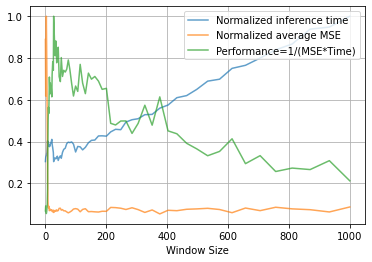

In [135]:
plt.figure()
plt.plot(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.plot(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.plot(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()

print(f'Best window inference time={np.argmin(inf_time_norm)} steps, time={"{:.2f}".format(np.min(inf_time)*1000)} ms')
print(f'Best window MSE loss={np.argmin(loss_norm)} steps, MSE={"{:.2e}".format(np.min(loss))}')
print(f'Best window Performance (MSExTime)={np.argmax(performance)} steps, Value={"{:.2e}".format(np.max(performance))}')

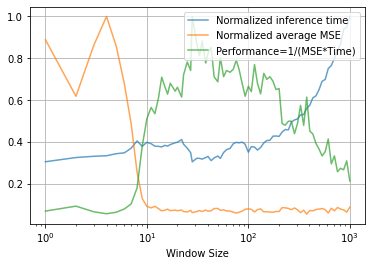

In [136]:
plt.figure()
plt.semilogx(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.semilogx(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.semilogx(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()

In [137]:
import matplotlib.patches as mpatches
from scipy.signal import savgol_filter
inf_time_norm_hat = np.clip(savgol_filter(inf_time_norm, 31, 3, mode='interp'), 0,1)  # window size 51, polynomial order 3
loss_norm_hat = np.clip(savgol_filter(loss_norm, 31, 3, mode='interp'), 0,1)   # window size 51, polynomial order 3
performance_hat = np.clip(savgol_filter(performance, 31, 3, mode='interp'), 0,1)   # window size 51, polynomial order 3

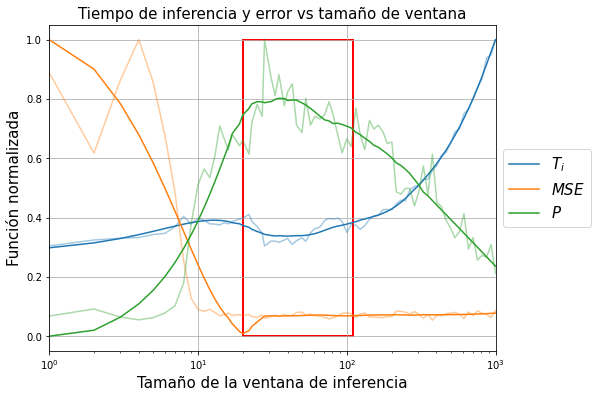

In [145]:
plt.figure(figsize = (8,6))
plt.semilogx(window_len, inf_time_norm, label='_nolegend_', alpha=0.4)
plt.semilogx(window_len, inf_time_norm_hat, label='$T_i$', alpha=1, color='tab:blue')
plt.semilogx(window_len, loss_norm, label='_nolegend_', alpha=0.4)
plt.semilogx(window_len, loss_norm_hat, label='$MSE$', alpha=1, color='tab:orange')
plt.semilogx(window_len, performance, label='_nolegend_', alpha=0.4)
plt.semilogx(window_len, performance_hat, label='$P$', alpha=1, color='tab:green')
#plt.semilogx(window_len, performance, label='P', alpha=0.8)
left, bottom, width, height = (20, 0, 90, 1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
fontSize = 15
plt.xlabel("Tamaño de la ventana de inferencia", fontsize=fontSize)
plt.ylabel("Función normalizada",fontsize=fontSize)
plt.title("Tiempo de inferencia y error vs tamaño de ventana", fontsize=fontSize)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontSize)
plt.xlim(1,1000)
plt.grid()
plt.savefig("../Imágenes/window_vs_error.svg")

In [146]:
print(f'Best window inference time={np.argmin(inf_time_norm)} steps, time={"{:.2f}".format(np.min(inf_time)*1000)} ms')
print(f'Best window MSE loss={np.argmin(loss_norm_hat)} steps, MSE={"{:.2e}".format(np.min(loss))}')
print(f'Best window Performance (MSExTime)={np.argmax(performance)} steps, Value={"{:.2e}".format(np.max(loss)/np.min(inf_time))}')

Best window inference time=23 steps, time=34.53 ms
Best window MSE loss=18 steps, MSE=2.48e-03
Best window Performance (MSExTime)=23 steps, Value=1.34e+00


In [141]:
(-performance).argsort()[:4]

array([23, 26, 24, 29], dtype=int64)